In [1]:
from pathlib import Path
import os
import sys
import xarray as xr
import rioxarray
import geopandas as gpd
from shapely.geometry import mapping
import pandas as pd
import numpy as np

In [2]:
path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
print(path_mod)
sys.path.append(path_mod)
from indicators.drought.config import Config
from utils_general.plotting import plot_raster_boundaries, plot_timeseries
from indicators.drought.utils import parse_args
from utils_general.utils import config_logger
from indicators.drought.chirps_rainfallobservations import get_chirps_data,chirps_plot_alldates

/Users/tinkavalentijn/Documents/CHD/AAFI/pa-anticipatory-action/


In [70]:
xr.__version__

'0.16.2'

In [71]:
rioxarray.__version__

'0.1.1'

In [3]:
config = Config()
country = "malawi"
parameters = config.parameters(country)
adm1_path=os.path.join(config.DIR_PATH,config.ANALYSES_DIR,country,config.DATA_DIR,config.SHAPEFILE_DIR,parameters['path_admin1_shp'])

In [4]:
#assuming data is already downloaded, else add download=True
ds,transform = get_chirps_data(config, 2020)

In [5]:
year=2020

In [6]:
ds_3011=ds.sel(time=f"{year}-11-30").squeeze()

<Figure size 432x288 with 0 Axes>

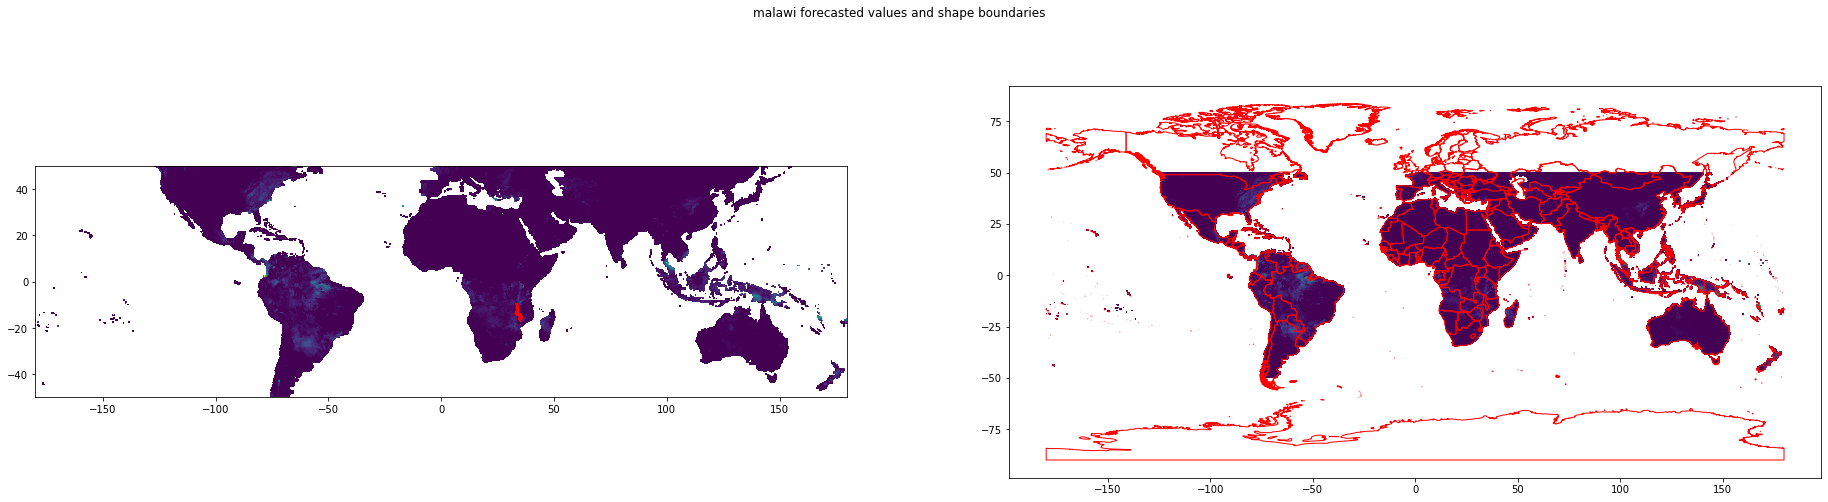

In [7]:
#check that data overlaps correctly with country boundaries
fig_bound=plot_raster_boundaries(ds_3011, country, parameters, config,forec_val="precip")

/Users/tinkavalentijn/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tinkavalentijn/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


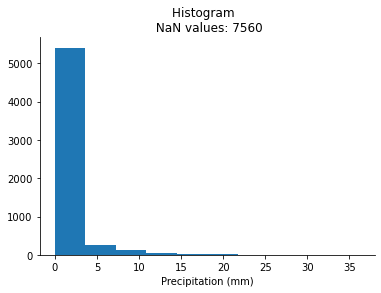

<Figure size 432x288 with 0 Axes>

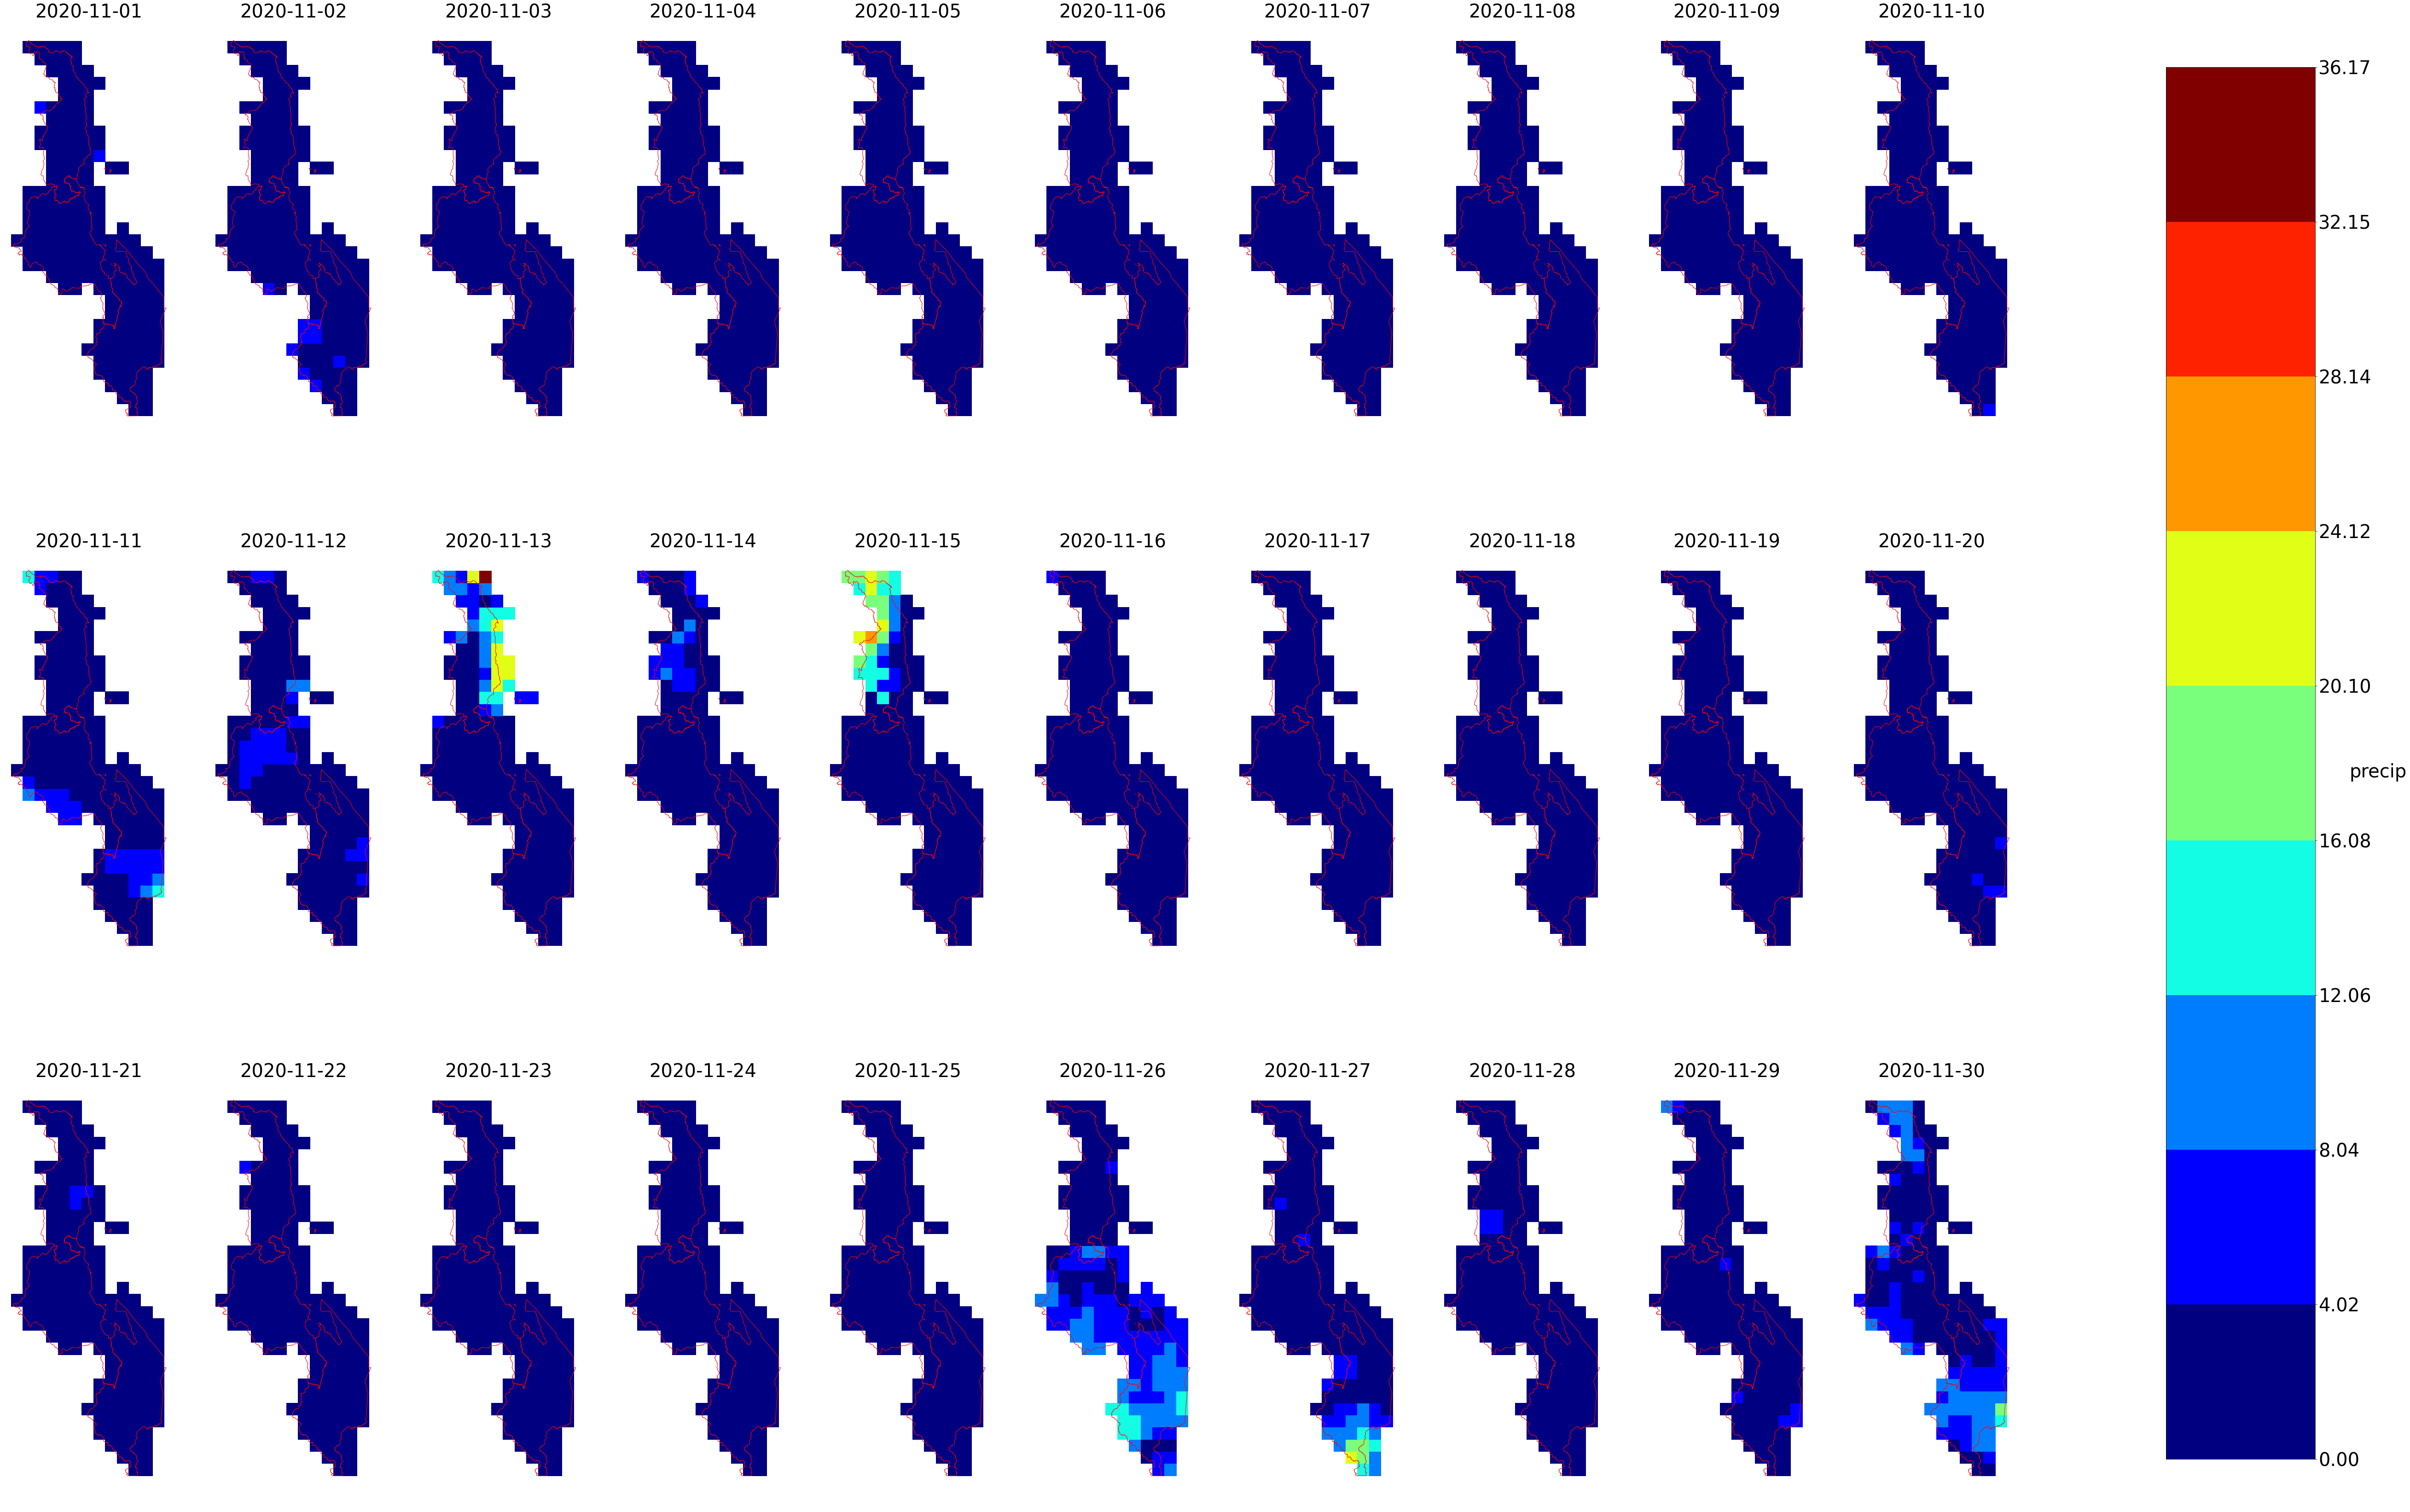

In [8]:
#plot histogram and example of data for a month
ds_nov=ds.sel(time=slice(f"{year}-11-01",f"{year}-11-30"))
fig_histo,fig_dates=chirps_plot_alldates(ds_nov, adm1_path, config)

### CHIRPS rolling sum

In [9]:
#have to implement to concat different years
# years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
years=[2020]

In [45]:
for i in years:
    ds,transform = get_chirps_data(config, i)
    df_bound = gpd.read_file(adm1_path)
    #clip global to malawi to speed up calculating rolling sum
    ds_clip = ds.rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.clip(df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)
    # rolling sum of 14 days. Uses right side of the window, i.e. sum of last 14 days
    ds_roll=ds_clip.rolling(time=14).sum()

In [46]:
ds_clip

<xarray.Dataset>
Dimensions:      (lat: 32, lon: 14, time: 335)
Coordinates:
  * lat          (lat) float64 -17.12 -16.88 -16.62 ... -9.875 -9.625 -9.375
  * lon          (lon) float64 32.62 32.88 33.12 33.38 ... 35.38 35.62 35.88
  * time         (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-11-30
    spatial_ref  int64 0
Data variables:
    precip       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2020-12-16
    creator_name:      Pete Peterson
    creator_email:     pete@geog.ucsb.edu
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day....
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ
    grid_mapping:      spatial_ref

In [47]:
ds_roll

<xarray.Dataset>
Dimensions:      (lat: 32, lon: 14, time: 335)
Coordinates:
  * lat          (lat) float64 -17.12 -16.88 -16.62 ... -9.875 -9.625 -9.375
  * lon          (lon) float64 32.62 32.88 33.12 33.38 ... 35.38 35.62 35.88
  * time         (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-11-30
    spatial_ref  int64 0
Data variables:
    precip       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2020-12-16
    creator_name:      Pete Peterson
    creator_email:     pete@geog.ucsb.edu
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day....
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ
    grid_mapping:      spatial_ref

In [66]:
print(np.unique(ds_roll.precip.values.flatten()[~np.isnan(ds_roll.precip.values.flatten())]))

[-6.5326691e-05 -6.5267086e-05 -6.4849854e-05 ...  3.2384406e+02
  3.2492273e+02  3.2524567e+02]


In [67]:
adm1_path=os.path.join(config.DIR_PATH,config.ANALYSES_DIR,country,config.DATA_DIR,config.SHAPEFILE_DIR,parameters['path_admin1_shp'])
download=False
for i in years:
    ds,transform = get_chirps_data(config, i, download = download)
    df_bound = gpd.read_file(adm1_path)
    #clip global to malawi to speed up calculating rolling sum
    ds_clip = ds.rio.set_spatial_dims(x_dim=config.LONGITUDE, y_dim=config.LATITUDE).rio.clip(
        df_bound.geometry.apply(mapping), df_bound.crs, all_touched=True)
    # rolling sum of 14 days
    ds_roll=ds_clip.rolling(time=14).sum()
    print(ds_roll)

<xarray.Dataset>
Dimensions:      (lat: 32, lon: 14, time: 335)
Coordinates:
  * lat          (lat) float64 -17.12 -16.88 -16.62 ... -9.875 -9.625 -9.375
  * lon          (lon) float64 32.62 32.88 33.12 33.38 ... 35.38 35.62 35.88
  * time         (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-11-30
    spatial_ref  int64 0
Data variables:
    precip       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2020-12-16
    creator_name:      Pete Peterson
    creator_email:     pete@geog.ucsb.edu
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given

In [69]:
print(np.sort(np.unique(ds_roll.precip.values.flatten()[~np.isnan(ds_roll.precip.values.flatten())])))

[-6.5326691e-05 -6.5267086e-05 -6.4849854e-05 ...  3.2384406e+02
  3.2492273e+02  3.2524567e+02]


In [48]:
#somehow negative values so something is not going 100% correctly.. In unrolled data there don't seem to be negative values
df_roll=ds_roll.to_dataframe().drop("spatial_ref",axis=1).reset_index()

In [49]:
df_roll.sort_values("precip")

,lat,lon,time,precip
26869,-15.875,35.125,2020-03-10,-0.000065
27007,-15.875,35.125,2020-07-26,-0.000065
27008,-15.875,35.125,2020-07-27,-0.000065
26980,-15.875,35.125,2020-06-29,-0.000065
26981,-15.875,35.125,2020-06-30,-0.000065
...,...,...,...,...
150075,-9.375,35.875,2020-11-26,NaN
150076,-9.375,35.875,2020-11-27,NaN
150077,-9.375,35.875,2020-11-28,NaN
150078,-9.375,35.875,2020-11-29,NaN


In [44]:
df_roll.dropna().sort_values("precip")

,lat,lon,time,precip
27008,-15.875,35.125,2020-07-27,-0.000065
27007,-15.875,35.125,2020-07-26,-0.000065
26869,-15.875,35.125,2020-03-10,-0.000065
26981,-15.875,35.125,2020-06-30,-0.000065
26980,-15.875,35.125,2020-06-29,-0.000065
...,...,...,...,...
133400,-10.125,34.125,2020-03-11,310.923615
133399,-10.125,34.125,2020-03-10,316.859955
133401,-10.125,34.125,2020-03-12,323.844055
133402,-10.125,34.125,2020-03-13,324.922729


In [12]:
#set to 1 if a cell received less than 2mm over 14 days
df_roll["dryspell"]=np.where(df_roll["precip"]<=2,1,0)

In [13]:
df_roll.groupby("time").sum().sort_values("dryspell")

,lat,lon,precip,dryspell
time,,,,
2020-01-14,-2643.0,6714.5,25088.966797,0
2020-11-04,-2643.0,6714.5,1781.041260,0
2020-11-03,-2643.0,6714.5,1780.428345,0
2020-11-02,-2643.0,6714.5,1774.548340,0
2020-03-12,-2643.0,6714.5,12986.607422,0
...,...,...,...,...
2020-09-15,-2643.0,6714.5,113.363426,176
2020-07-01,-2643.0,6714.5,96.299026,181
2020-06-28,-2643.0,6714.5,85.776901,191


### Attempt to understand negative values (without success)
When rolling sum some small negative values appear where there should actually be postivie values

In [21]:
df=ds_clip.to_dataframe().reset_index().drop("spatial_ref",axis=1)

In [24]:
df.dropna().sort_values("precip")

,lat,lon,time,precip
64259,-13.875,34.875,2020-10-01,0.000000
72142,-13.375,33.875,2020-04-27,0.000000
72143,-13.375,33.875,2020-04-28,0.000000
72144,-13.375,33.875,2020-04-29,0.000000
72147,-13.375,33.875,2020-05-02,0.000000
...,...,...,...,...
142474,-9.625,33.875,2020-04-09,89.140335
100898,-11.875,34.375,2020-03-04,89.482674
142138,-9.625,33.625,2020-04-08,92.865433
141803,-9.625,33.375,2020-04-08,96.652496


In [26]:
from datetime import timedelta

In [30]:
end_date=pd.to_datetime("2020-03-10")
df[(df['time'] > end_date-timedelta(days=14)) & (df['time'] <= end_date) & (df["lat"]==-13.875) & (df["lon"]==34.875)]

,lat,lon,time,precip
64041,-13.875,34.875,2020-02-26,0.518024
64042,-13.875,34.875,2020-02-27,0.000000
64043,-13.875,34.875,2020-02-28,0.000000
64044,-13.875,34.875,2020-02-29,0.755869
64045,-13.875,34.875,2020-03-01,0.000000
64046,-13.875,34.875,2020-03-02,0.000000
64047,-13.875,34.875,2020-03-03,0.000000
64048,-13.875,34.875,2020-03-04,0.968134
64049,-13.875,34.875,2020-03-05,0.000000
64050,-13.875,34.875,2020-03-06,0.000000


In [33]:
df[(df['time'] > end_date-timedelta(days=14)) & (df['time'] <= end_date) & (df["lat"]==-13.875) & (df["lon"]==34.875)].rolling(14).sum()

,lat,lon,precip
64041,NaN,NaN,NaN
64042,NaN,NaN,NaN
64043,NaN,NaN,NaN
64044,NaN,NaN,NaN
64045,NaN,NaN,NaN
64046,NaN,NaN,NaN
64047,NaN,NaN,NaN
64048,NaN,NaN,NaN
64049,NaN,NaN,NaN
64050,NaN,NaN,NaN


In [37]:
end_date=pd.to_datetime("2020-03-14")
df[(df['time'] > end_date-timedelta(days=14)) & (df['time'] <= end_date) & (df["lat"]==-10.125) & (df["lon"]==34.125)]

,lat,lon,time,precip
133390,-10.125,34.125,2020-03-01,34.036640
133391,-10.125,34.125,2020-03-02,50.241997
133392,-10.125,34.125,2020-03-03,32.652229
133393,-10.125,34.125,2020-03-04,45.948536
133394,-10.125,34.125,2020-03-05,18.653870
133395,-10.125,34.125,2020-03-06,8.695344
133396,-10.125,34.125,2020-03-07,5.547907
133397,-10.125,34.125,2020-03-08,33.019928
133398,-10.125,34.125,2020-03-09,30.470964
133399,-10.125,34.125,2020-03-10,22.595762


In [38]:
df[(df['time'] > end_date-timedelta(days=14)) & (df['time'] <= end_date) & (df["lat"]==-10.125) & (df["lon"]==34.125)].rolling(14).sum()

,lat,lon,precip
133390,NaN,NaN,NaN
133391,NaN,NaN,NaN
133392,NaN,NaN,NaN
133393,NaN,NaN,NaN
133394,NaN,NaN,NaN
133395,NaN,NaN,NaN
133396,NaN,NaN,NaN
133397,NaN,NaN,NaN
133398,NaN,NaN,NaN
133399,NaN,NaN,NaN


In [ ]:
df.groupby(["lon","lat"]).sum().rolling(14).sum()

In [65]:
df.groupby(["lon","lat"])["precip"].rolling(14).sum().reset_index().dropna().sort_values(by="precip")

,lon,lat,level_2,precip
100346,34.875,-14.375,54786,-8.881784e-16
100444,34.875,-14.375,54884,-8.881784e-16
100443,34.875,-14.375,54883,-8.881784e-16
100442,34.875,-14.375,54882,-8.881784e-16
100354,34.875,-14.375,54794,-8.881784e-16
...,...,...,...,...
73770,34.125,-10.125,133400,3.109236e+02
73769,34.125,-10.125,133399,3.168599e+02
73771,34.125,-10.125,133401,3.238440e+02
73772,34.125,-10.125,133402,3.249227e+02
